# Project 3: Web APIs & NLP

## Problem Statement

In this project, I collect posts from two subreddits (r/boston and r/seattle) using Pushshift's API. The goal of this project is to classify posts from two different subreddits. I will create and compare two models: logistic regression model and random forest model.

Our results may be useful for any reddit individual or business users to see what keywords/contents people are interested most from two cities. We also use sentiment analysis to check if people have postive or negative comments on Boston and Seattle. 

## Data Collection

In [302]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import plot_confusion_matrix

from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [242]:
# Define function to scrape data
def scrape_data(urls, num_req):
    posts = []
    for url in list(urls):
        after = None
        for i in list(range(num_req)):
            if after == None:
                params = {}
            else:
                params = {'after': after}
            res  = requests.get(url, params = params, headers={'User-agent': 'Data Inc'})
            if res.status_code == 200:
                the_json = res.json()
                posts.extend(the_json['data']['children'])
                after = the_json['data']['after']
            else:
                print(res.status_code)
                break
    
    subreddits, selftexts, titles = [], [], []
    for i in range(len(posts)):
        subreddits.append(posts[i]['data']['subreddit'])
        selftexts.append(posts[i]['data']['selftext'])
        titles.append(posts[i]['data']['title'])
    return pd.DataFrame({'subreddit': subreddits, 'selftext': selftexts, 'title': titles})

In [243]:
# Scrape posts from subreddits
df = scrape_data([
    'https://www.reddit.com/r/seattle.json',
    'https://www.reddit.com/r/boston.json'
], num_req=50)

KeyboardInterrupt: 

In [ ]:
# Save data
df.to_csv('./data/posts.csv', index=False)

## Data Cleaning & EDA

In [244]:
# Import data
df = pd.read_csv('./data/posts.csv')

In [245]:
df.head()

,subreddit,selftext,title
0,Seattle,Hey folks! It's been a while since we posted o...,Best of Seattle 2021: /r/Seattle Recommendatio...
1,Seattle,Please join our [Discord](https://discord.gg/Y...,"Weekly ""What's Happening"" general discussion a..."
2,Seattle,NaN,Does anyone have an explanation for this monst...
3,Seattle,NaN,"Another Saturday, another urban hike. Chilly b..."
4,Seattle,NaN,Colorful sky tonight


In [246]:
df.shape

(1785, 3)

In [247]:
df.isnull().sum()

subreddit      0
selftext     752
title          0
dtype: int64

In [248]:
# fill NaN
df.fillna('', inplace=True)

In [249]:
df.isnull().sum()

subreddit    0
selftext     0
title        0
dtype: int64

In [250]:
# Combine title and selftext in one column
df['title_text'] = df['title'] + ' ' + df['selftext']

In [251]:
df['subreddit'].value_counts()

boston     944
Seattle    841
Name: subreddit, dtype: int64

In [252]:
# Convert subreddit to binary
df['seattle'] = df['subreddit'].map({'boston':0, 'Seattle':1})

### CountVectorizer

In [253]:
# CountVectorizer boston
cvec = CountVectorizer(stop_words='english')

df_boston = df[df.subreddit == 'boston']['title_text']

cvec.fit(df_boston)

title_text_cvec = cvec.transform(df_boston)

df_bos_cvec = pd.DataFrame(title_text_cvec.todense(), columns=cvec.get_feature_names())

In [254]:
# top 60 words
df_bos_cvec.sum().sort_values(ascending=False).head(60)

boston             663
https              190
like               185
know               169
just               161
looking            140
www                135
com                127
going              124
ve                 120
city               119
covid              117
time               116
best               116
good               103
don                 99
places              98
today               97
new                 97
does                96
area                92
things              87
19                  86
thanks              82
questions           81
people              76
place               76
thread              73
need                73
news                72
line                68
day                 66
mass                66
local               64
want                63
really              62
mbta                61
year                61
days                60
winter              59
help                58
information         57
work                55
general    

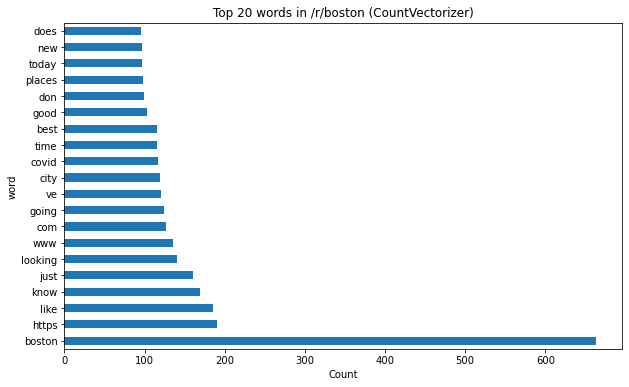

In [255]:
# Plot top 20 words in r/boston
plt.figure(figsize=(10, 6))
df_bos_cvec.sum().sort_values(ascending=False).head(20).plot(kind='barh')
plt.title('Top 20 words in /r/boston (CountVectorizer)')
plt.xlabel('Count')
plt.ylabel('word');

In [256]:
# CountVectorizer seattle
cvec = CountVectorizer(stop_words='english')

df_seattle = df[df.subreddit == 'Seattle']['title_text']

cvec.fit(df_seattle)

title_text_cvec = cvec.transform(df_seattle)

df_sea_cvec = pd.DataFrame(title_text_cvec.todense(), columns=cvec.get_feature_names())

In [257]:
df_sea_cvec.sum().sort_values(ascending=False).head(60)

seattle            519
like               238
just               232
know               193
ve                 167
looking            149
people             140
good               139
don                120
area               115
city               109
want               104
new                103
time               100
car                 95
thanks              93
https               92
work                88
place               86
does                85
help                79
year                79
got                 74
amp                 73
going               72
really              72
recommendations     72
need                70
make                70
lot                 67
open                65
com                 64
way                 63
things              63
best                61
day                 59
home                59
places              58
state               56
washington          55
homeless            54
ll                  53
local               53
experience 

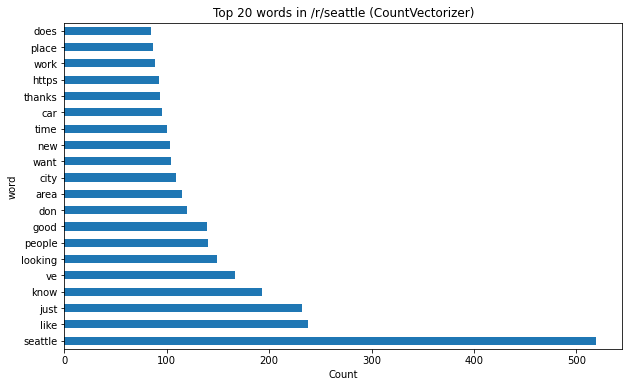

In [258]:
# Plot top 20 words in r/seattle
plt.figure(figsize=(10, 6))
df_sea_cvec.sum().sort_values(ascending=False).head(20).plot(kind='barh')
plt.title('Top 20 words in /r/seattle (CountVectorizer)')
plt.xlabel('Count')
plt.ylabel('word');

### TfidfVectorizer

In [259]:
# TfidfVectorizer boston
tvec = TfidfVectorizer(stop_words='english', min_df=5, ngram_range=(1,3))

df_boston = df[df.subreddit == 'boston']['title_text']

tvec.fit(df_boston)

title_text_tvec = tvec.transform(df_boston)

df_bos_tvec = pd.DataFrame(title_text_tvec.todense(), columns=tvec.get_feature_names())

In [260]:
# top 60 words
df_bos_tvec.sum().sort_values(ascending=False).head(60)

boston             55.523245
know               18.767233
like               18.420043
city               18.073243
just               17.759113
looking            17.479946
today              16.427961
good               16.286324
best               15.196814
time               14.821412
new                14.117331
does               13.606385
ve                 13.598878
area               13.508688
don                12.071362
covid              11.088372
people             11.015148
thanks             10.690514
street             10.594397
place              10.469559
year               10.333429
mass               10.311553
line               10.096792
going              10.043435
want                9.858425
need                9.502301
places              9.443673
winter              9.333372
recommendations     9.150041
public              9.123894
https               9.055492
near                9.039873
massachusetts       8.806619
amp                 8.539623
ma            

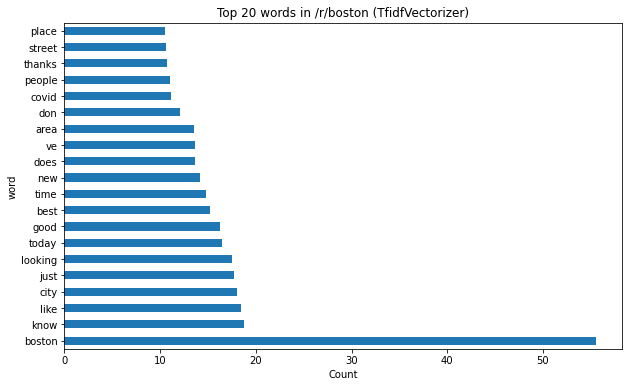

In [261]:
# Plot top 20 words in r/boston
plt.figure(figsize=(10, 6))
df_bos_tvec.sum().sort_values(ascending=False).head(20).plot(kind='barh')
plt.title('Top 20 words in /r/boston (TfidfVectorizer)')
plt.xlabel('Count')
plt.ylabel('word');

In [262]:
# TfidfVectorizer seattle
tvec = TfidfVectorizer(stop_words='english', min_df=5, ngram_range=(1,3))

df_seattle = df[df.subreddit == 'Seattle']['title_text']

tvec.fit(df_seattle)

title_text_tvec = tvec.transform(df_seattle)

df_sea_tvec = pd.DataFrame(title_text_tvec.todense(), columns=tvec.get_feature_names())

In [263]:
# top 60 words
df_sea_tvec.sum().sort_values(ascending=False).head(60)

seattle            47.860853
like               19.617216
just               19.501655
know               19.121477
looking            18.004019
good               18.003913
ve                 15.425755
city               14.068332
area               13.642457
new                12.898786
place              12.449870
want               11.954358
thanks             11.711966
people             11.702284
washington         11.398191
time               11.152376
does               11.080797
help               11.075024
recommendations    10.928417
work               10.880916
car                10.401480
don                10.257363
best               10.165567
need               10.088156
day                 9.990395
year                9.951386
police              9.560981
going               9.478291
state               8.987488
got                 8.970630
things              8.884901
way                 8.676011
places              8.533761
home                8.443544
near          

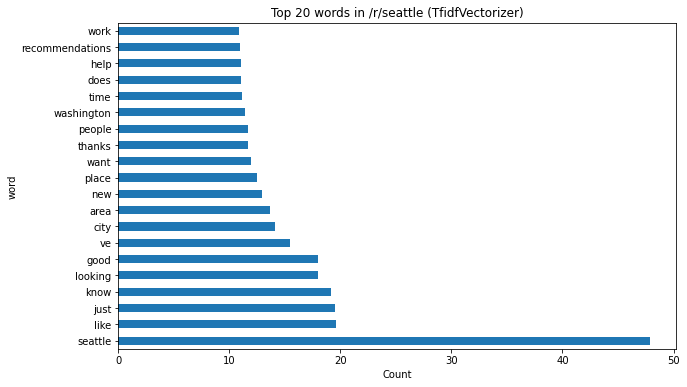

In [264]:
# Plot top 20 words in r/seattle
plt.figure(figsize=(10, 6))
df_sea_tvec.sum().sort_values(ascending=False).head(20).plot(kind='barh')
plt.title('Top 20 words in /r/seattle (TfidfVectorizer)')
plt.xlabel('Count')
plt.ylabel('word');

## Preprocessing & Modeling

In [265]:
X = df['title_text']
y = df['seattle']

In [266]:
# Baseline accuracy
y.value_counts(normalize=True)

0    0.528852
1    0.471148
Name: seattle, dtype: float64

In [267]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

### Logistic regression model

In [268]:
cvec = CountVectorizer(stop_words='english')

In [269]:
logreg = LogisticRegression()

In [270]:
pipe1 = Pipeline([
    ('cvec', cvec),
    ('logreg', logreg)
])

In [271]:
cross_val_score(pipe1, X_train, y_train, cv=5).mean()

0.7900357761753033

In [272]:
pipe1.fit(X_train, y_train)

Pipeline(steps=[('cvec', CountVectorizer(stop_words='english')),
                ('logreg', LogisticRegression())])

In [273]:
pipe1.score(X_train, y_train), pipe1.score(X_test, y_test)

(0.9955156950672646, 0.8299776286353467)

### GridSearchCV

In [308]:
params = {
    'cvec__ngram_range': [(1,1), (1,2)],
    'cvec__min_df': [1, 2],
    'cvec__max_df': [.5, .6, .7],
    'cvec__max_features': [None, 500, 1000]
}
gs1 = GridSearchCV(pipe1, param_grid=params)
gs1.fit(X_train, y_train)
print(gs1.best_score_)
gs1.best_params_

0.791522723461345


{'cvec__max_df': 0.5,
 'cvec__max_features': None,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2)}

In [309]:
gs1.score(X_train, y_train), gs1.score(X_test, y_test)

(0.9932735426008968, 0.8389261744966443)

### Random forest model

In [278]:
cvec = CountVectorizer(stop_words='english')

In [279]:
rf = RandomForestClassifier(random_state=42)

In [280]:
pipe2 = Pipeline([
    ('cvec', cvec),
    ('rf', rf)
])

In [281]:
cross_val_score(pipe2, X_train, y_train, cv=5).mean()

0.7765442450668008

In [282]:
pipe2.fit(X_train, y_train)

Pipeline(steps=[('cvec', CountVectorizer(stop_words='english')),
                ('rf', RandomForestClassifier(random_state=42))])

In [283]:
pipe2.score(X_train, y_train), pipe2.score(X_test, y_test)

(1.0, 0.8076062639821029)

In [310]:
params = {
    'cvec__ngram_range': [(1,1), (1,2)],
    'cvec__min_df': [1, 2],
    'cvec__max_df': [.5, .6, .7],
    'cvec__max_features': [None, 500, 1000]
}
gs2 = GridSearchCV(pipe2, param_grid=params)
gs2.fit(X_train, y_train)
print(gs2.best_score_)
gs2.best_params_

0.8042232656940019


{'cvec__max_df': 0.5,
 'cvec__max_features': None,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2)}

In [285]:
gs2.score(X_train, y_train), gs2.score(X_test, y_test)

(0.9985052316890882, 0.8277404921700223)

### Sentiment Analysis

In [286]:
sia = SentimentIntensityAnalyzer()

In [287]:
def get_sentiment(text):
    sentiment = sia.polarity_scores(text)
    return sentiment['compound']
df['sentiment'] = df['title_text'].apply(get_sentiment)

In [288]:
df['sentiment']

0       0.9952
1       0.9472
2       0.0000
3       0.9428
4       0.0000
         ...  
1780    0.0000
1781    0.9169
1782    0.0000
1783    0.8591
1784    0.0772
Name: sentiment, Length: 1785, dtype: float64

In [289]:
df[df.subreddit == 'Seattle']['sentiment'].mean()

0.2940524375743163

In [290]:
(df[df.subreddit == 'Seattle']['title_text'].apply(get_sentiment) > 0).astype(int).value_counts(normalize=True)

1    0.581451
0    0.418549
Name: title_text, dtype: float64

In [291]:
df[df.subreddit == 'boston']['sentiment'].mean()

0.2616880296610165

In [292]:
(df[df.subreddit == 'boston']['title_text'].apply(get_sentiment) > 0).astype(int).value_counts(normalize=True)

1    0.532839
0    0.467161
Name: title_text, dtype: float64

## Evaluation and Conceptual Understanding

In [315]:
# Generate a confusion matrix for Logistic regression model
y_pred_log = gs1.predict(X_test)

In [316]:
pd.DataFrame(confusion_matrix(y_test, y_pred_log),
            columns=['predit/r/boston', 'predit/r/seattle'],
            index=['actual/r/boston', 'actual/r/seattle'])

,predit/r/boston,predit/r/seattle
actual/r/boston,211,25
actual/r/seattle,47,164


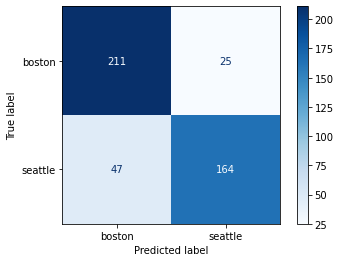

In [317]:
plot_confusion_matrix(gs1, X_test, y_test, cmap='Blues',
                     display_labels=['boston', 'seattle']);

In [318]:
# Examine classification metrics 
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_log).ravel()
print('Accuracy: {}'.format(round((tp+tn)/(tp+fp+tn+fn),4)))
print('Misclassification rate: {}'.format(round((fp+fn)/(tp+fp+tn+fn),4)))
print('Precision: {}'.format(round(tp/(tp+fp),4)))
print('Recall: {}'.format(round(tp/(tp+fn),4)))
print('Specificity: {}'.format(round(tn/(tn+fp),4)))

Accuracy: 0.8389
Misclassification rate: 0.1611
Precision: 0.8677
Recall: 0.7773
Specificity: 0.8941


In [319]:
# Generate a confusion matrix for Random forest model
y_pred_rf = gs2.predict(X_test)

In [320]:
pd.DataFrame(confusion_matrix(y_test, y_pred_rf),
            columns=['predit/r/boston', 'predit/r/seattle'],
            index=['actual/r/boston', 'actual/r/seattle'])

,predit/r/boston,predit/r/seattle
actual/r/boston,209,27
actual/r/seattle,50,161


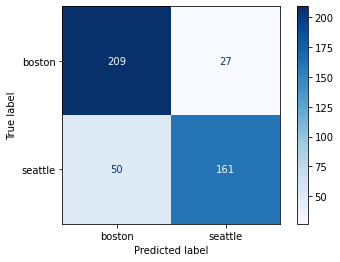

In [322]:
plot_confusion_matrix(gs2, X_test, y_test, cmap='Blues',
                     display_labels=['boston', 'seattle']);

In [321]:
# Examine classification metrics 
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_rf).ravel()
print('Accuracy: {}'.format(round((tp+tn)/(tp+fp+tn+fn),4)))
print('Misclassification rate: {}'.format(round((fp+fn)/(tp+fp+tn+fn),4)))
print('Precision: {}'.format(round(tp/(tp+fp),4)))
print('Recall: {}'.format(round(tp/(tp+fn),4)))
print('Specificity: {}'.format(round(tn/(tn+fp),4)))

Accuracy: 0.8277
Misclassification rate: 0.1723
Precision: 0.8564
Recall: 0.763
Specificity: 0.8856


When we compare two models, it seems that logistic regression model performs better than random forest model. 

In the logistic regression model:
- The model correctly predicts 83.39% of observations.
- From all posts that the model predicted to be in r/seattle, we have 86.67% of them correctly classified.
- From all posts that are in r/seattle, we have 77.73% of them correctly classified.
- From all posts that are in r/boston, we have 89.41% of them correctly classified.

## Conclusion and Recommendations

Our logistic regression model performed well with an accuracy score of 83.39%. The random forest model works equally with score of 82.77%.

Sentiment analysis shows that the comments in r/seattle are slightly positive overall than r/boston. However, we can't conclude which city is better before doing further research.

Future improvements:
 - Choose significantly different subreddits may improve the model.
 - Collect more data sample. Split data in an appropriate way.
 - Include lemmatization, stemming and spell checks to have cleaned post texts.
 
 